## encoding street canyons using berlins building heights

Main extracted features:
- ``prop_intercept_50``: proportion (of 360°) with intersection (building) within 50 meter radius
- ``prop_intercept_200``: -||- within 200 meter radius
- ``border_values``: return beginning and ending degree [1,360] of open window of no obstacle  (200 meter radius)

 
Encoding Steps:
1. read dataset of building heights and geometry
2. exclude buildings below the height of X meter 
3. Main Functions:

``object_intersect_scan``: create spatial echo with lines distributed in all directions and cute if intersected with building polygon

``create_border_values_open_direction``: return beginning and ending degree [1,360] of open window of no obstacle 

``calc_valley``: combines previous functions and plots each location

``no_building_in_wind_degree``: combines meterological df with data from create_border_values_open_direction


In [15]:
# 1 load data and select features
import geopandas

sites = geopandas.read_file('../data/monitoring_station/monitoring_station.shp')[['id', 'geometry']] # id can be removed if not applicable for your dataset
building = geopandas.read_file('../data/building_polygon/building_polygon.shp')

# 1.2 check reference system - (no adjustment needed)
print(f'Coordinate Reference System monitoring sites: {sites.crs}')
print(f'Coordinate Reference System green volume: {building.crs}')

Coordinate Reference System monitoring sites: EPSG:25833
Coordinate Reference System green volume: EPSG:25833


##### filter for specific height building 
 - building hight has been remove from the original dataset to reduce the total file size -> if you are still interested load the original dataset as shapefile: [Geoportal Berlin / Gebäudehöhen (Umweltatlas)](https://fbinter.stadt-berlin.de/fb/index.jsp) (ps. disable VPN to access page)

In [16]:
# define which building height (germ. Höhe) is considered # adjust parameter in reference to literature
# relevant_height = 20
# building = building[['hoehe','geometry']]
# building = building[building['hoehe']> relevant_height] 

In [17]:
from shapely import geometry
import numpy

def object_intersect_scan(center_point, radius, intersect_polygon):
    '''
    create spatial echo with lines distributed in all directions and cute if intersected with building polygon
    --
    Input: 
        center_point: geometry - coordinate (geo point) of center 
        radius: int - radius 
        intersect_polygone: geometry of surroundings obstacle

    Return: 
        full_rays: Linestring (n=360) geometry
        distances: list (n=360) - length of lines [0, radius]

    '''
    #create rays (linestring) in 360 degree starting at north, doing counterclockwise
    rays = [geometry.LineString([
            center_point, 
            geometry.Point(
                center_point.x + numpy.sin(-angle) * radius, 
                center_point.y + numpy.cos(-angle) * radius
            )]) 
            for angle in numpy.linspace(0, 2 * numpy.pi, 360, endpoint=False)]

    distances = [] # list hold distance between center and closest polygon (building) for all lines
    full_rays = [] # keep only lines which reach border

    for ray in rays:
        min_distance = numpy.inf
        for polygon in intersect_polygon:
            if ray.intersects(polygon):
                intersection_point = ray.intersection(polygon)
                distance = center_point.distance(intersection_point)
                if distance < min_distance:
                    min_distance = distance 

        # store the only linestrings which intersects with border (length radius)      
        if min_distance == numpy.inf: 
            full_rays.append(ray)
        
        distances.append(min_distance if min_distance != numpy.inf else 0)
      
    return full_rays, distances


In [18]:
def create_border_values_open_direction(distances, degree_threshold = 5):
    ''' 
    converts ordered sequence of distance length to nested list with beginning and ending degree of open window
    Input: distances - list of len(360) with length of 360 degree lines 
    Output: nested list of beginning and end degree of each window of no building    
    '''
    # only keep degrees with no building within range
    degrees = [360 - i for i, e in enumerate(distances) if e == 0] # locate degrees which reach border
    degrees.sort()

    # cluster by groups 
    wind_directions = [] 
    current_directions = [degrees[0]]

    for degree in degrees[1:]:
        
        if degree -1 == current_directions[-1]:
            current_directions.append(degree)
        else:
            wind_directions.append(current_directions)
            current_directions = []
            current_directions.append(degree)

    wind_directions.append(current_directions)  

    # combine groups ending with 360 and beginning with 1 
    if (wind_directions[0][0] == 1) & (wind_directions[-1][-1] == 360):
        merged_degrees = wind_directions[-1] + wind_directions[0]
        if len(wind_directions) > 1:
            wind_directions.pop(0)
            wind_directions.pop(-1)
        wind_directions.append(merged_degrees)

    # drop directions with below defined degrees
    for wind_direction in wind_directions:
            if len(wind_direction) < degree_threshold:
                    wind_directions.remove(wind_direction)

    # create border_values, first and last value of sequence
    border_values = []

    for wind_direction in wind_directions:
        border_values.append([wind_direction[0], wind_direction[-1]])

    return border_values

In [19]:
import geopandas 
import matplotlib.pyplot as plt


def calc_valley(coordinate, radius, id = None,  plot = False, polygon = building):
    '''
    SPATIAL ECHO obstacle detection
    ---
    Input:
        coordinate: geopoint (monitoring site)
        radius: int
        id: str- name of site
        plot: boolean 
    '''

    buffer  = geopandas.GeoDataFrame(geometry= [coordinate.buffer(radius)], crs=polygon.crs) # create polygon with buffer region around monitoring point
    in_buffer_one = geopandas.overlay(polygon, buffer, how='intersection') # intersect with radius polygon to reduce to inside the radius 
         
    # calculate proportion of intersection in 50 meter range on 360 rays
    prop_intersect_50 = round(1 - len(object_intersect_scan(center_point = coordinate, radius = 50, intersect_polygon = in_buffer_one['geometry'])[0])/360,3)

    # return linestring and distance from analyis
    full_rays, len_rays = object_intersect_scan(center_point = coordinate, radius = radius, intersect_polygon = in_buffer_one['geometry'])

    # calculate proportion of intersection in 200 meter range on 360 rays
    prop_intersect_radius = round(1- len(full_rays)/360,3)  
      
    # beginning and ending degree [1,360] of open window of no obstacle    
    border_values = create_border_values_open_direction(distances = len_rays, degree_threshold = 5)

    if plot == True: 
        
        print(f'proportion of buildings (360°) in r=50m: {prop_intersect_50}')
        print(f'proportion of buildings (360°) in r={radius}m: {prop_intersect_radius}')
        
        # create additional buffer zones for orientation & lines which reach border
        buffer_50  = geopandas.GeoDataFrame(geometry= [coordinate.buffer(50)], crs=polygon.crs) 
        full_lines = geopandas.GeoDataFrame({'geometry': full_rays}, crs="EPSG:25833")
        
        ax = buffer.plot(alpha=0.1, edgecolor='black') # plot buffer radius outer
        buffer_50.plot(ax= ax, alpha=0.05, edgecolor='black') # plot buffer radius inner     
        full_lines.plot(ax=ax, alpha=0.1, edgecolor='purple') # plot lines which reach buffer border
        in_buffer_one.plot(ax=ax, cmap='Blues', legend=True, vmin= 10, vmax = 30) # plot building + height
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.title(f'{id} with radius of {radius}', size = 15, loc = "left")
        plt.suptitle(f'prop. of buildings (360°): {prop_intersect_50} (r=50m), {prop_intersect_radius} (r={radius}m)', size = 10)
        plt.savefig(f"output/street_canyon/buffer_{radius}_{id}.png", dpi = 300) # save plot
        plt.show() 
    
    return prop_intersect_radius, prop_intersect_50, border_values     

proportion of buildings (360°) in r=50m: 1.0
proportion of buildings (360°) in r=200m: 1.0


C:\Users\Ri_sc\AppData\Local\Temp\ipykernel_14744\2445363686.py:42: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  full_lines.plot(ax=ax, alpha=0.1, edgecolor='purple') # plot lines which reach buffer border


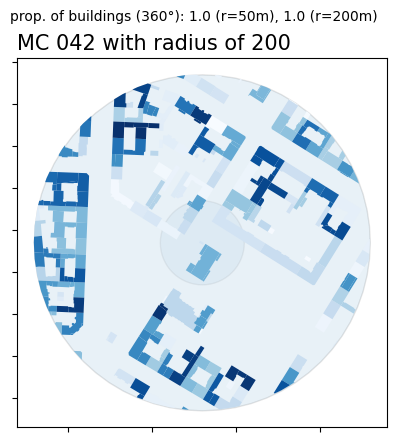

proportion of buildings (360°) in r=50m: 0.75
proportion of buildings (360°) in r=200m: 0.939


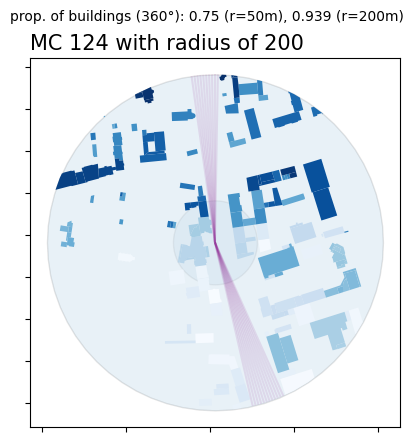

proportion of buildings (360°) in r=50m: 0.853
proportion of buildings (360°) in r=200m: 0.983


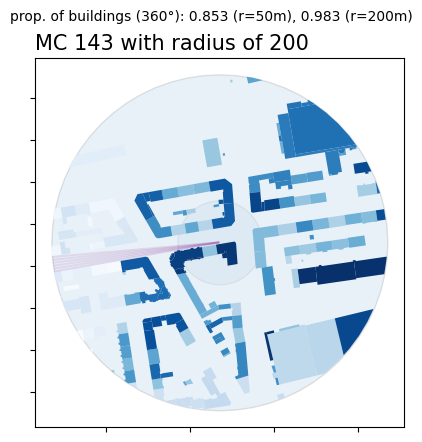

proportion of buildings (360°) in r=50m: 0.442
proportion of buildings (360°) in r=200m: 0.764


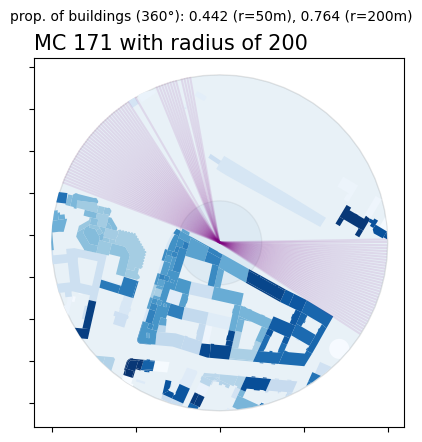

proportion of buildings (360°) in r=50m: 0.694
proportion of buildings (360°) in r=200m: 0.939


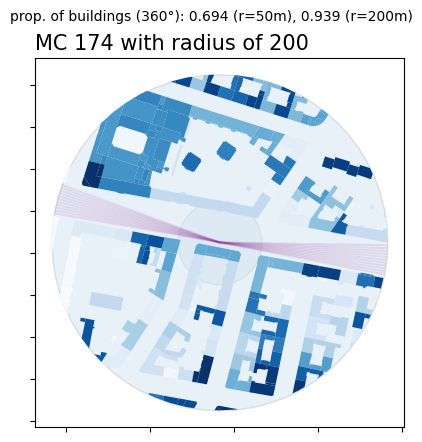

proportion of buildings (360°) in r=50m: 0.85
proportion of buildings (360°) in r=200m: 0.95


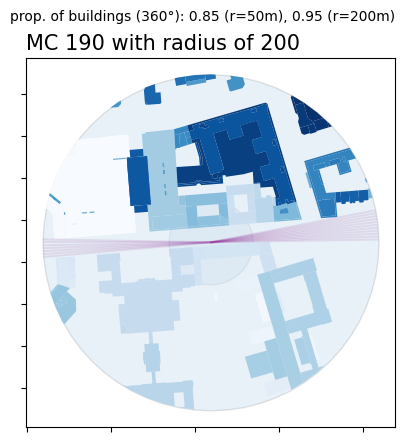

proportion of buildings (360°) in r=50m: 0.792
proportion of buildings (360°) in r=200m: 0.95


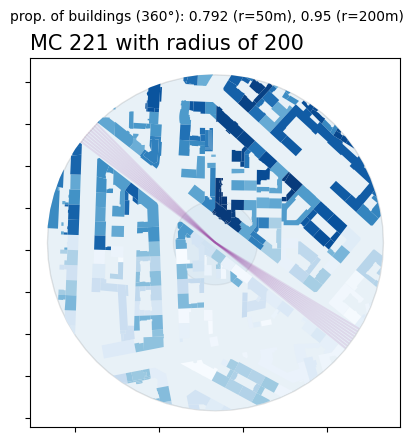

proportion of buildings (360°) in r=50m: 0.0
proportion of buildings (360°) in r=200m: 0.106


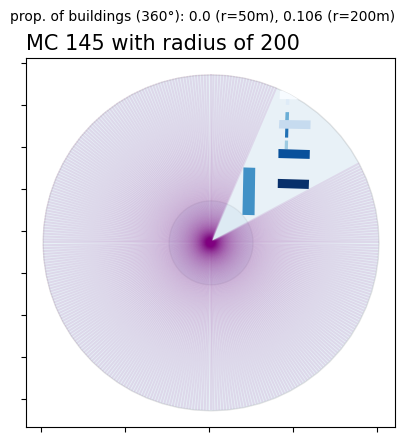

proportion of buildings (360°) in r=50m: 0.0
proportion of buildings (360°) in r=200m: 0.269


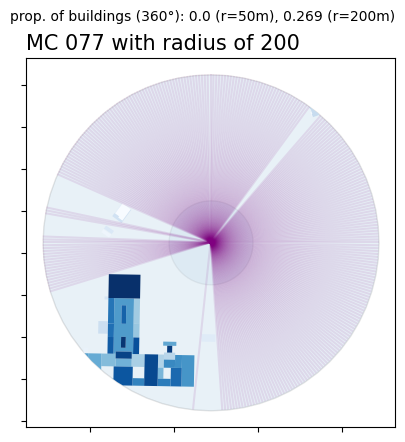

proportion of buildings (360°) in r=50m: 0.319
proportion of buildings (360°) in r=200m: 0.947


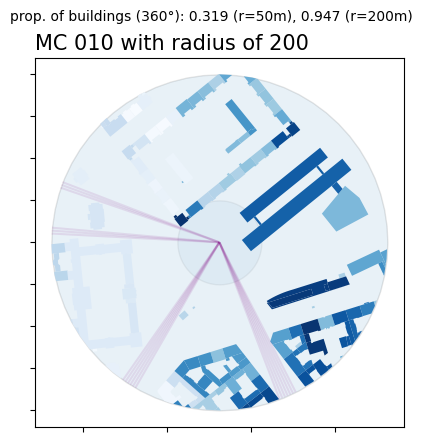

proportion of buildings (360°) in r=50m: 0.511
proportion of buildings (360°) in r=200m: 0.806


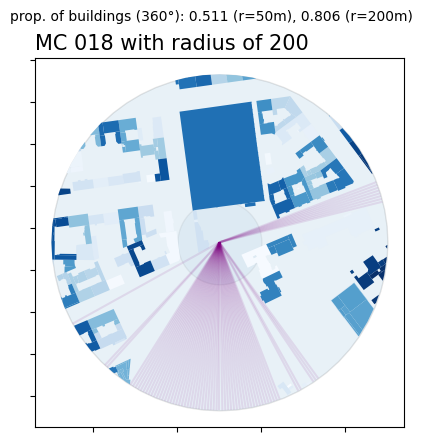

proportion of buildings (360°) in r=50m: 0.597
proportion of buildings (360°) in r=200m: 0.919


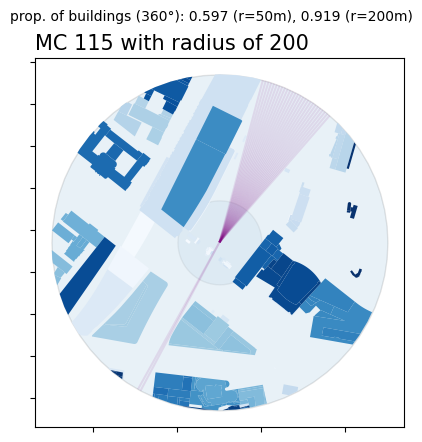

proportion of buildings (360°) in r=50m: 0.833
proportion of buildings (360°) in r=200m: 0.953


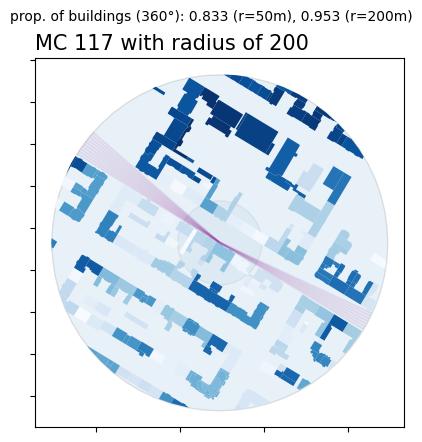

proportion of buildings (360°) in r=50m: 0.375
proportion of buildings (360°) in r=200m: 0.956


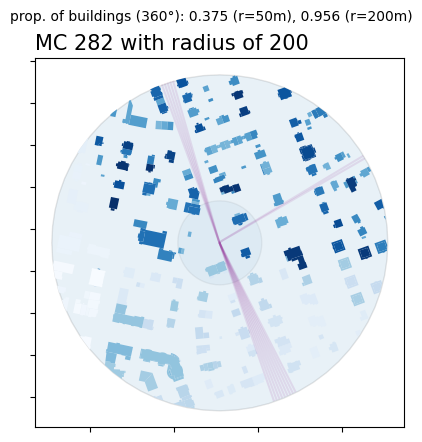

proportion of buildings (360°) in r=50m: 0.497
proportion of buildings (360°) in r=200m: 0.692


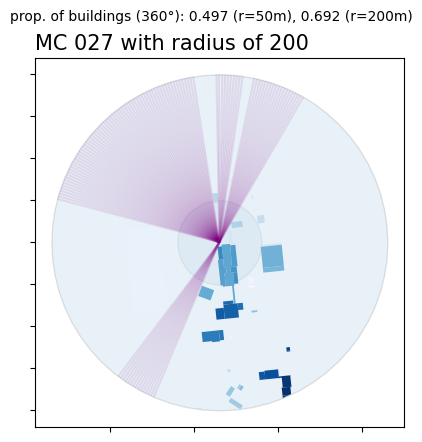

proportion of buildings (360°) in r=50m: 0.0
proportion of buildings (360°) in r=200m: 0.0


C:\Users\Ri_sc\AppData\Local\Temp\ipykernel_14744\2445363686.py:43: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  in_buffer_one.plot(ax=ax, cmap='Blues', legend=True, vmin= 10, vmax = 30) # plot building + height


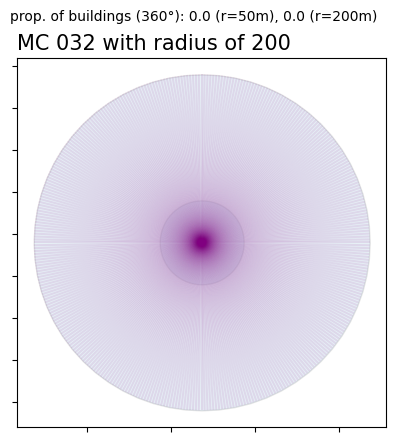

,id,border_values
0,mc042,"[[1, 360], [1, 360]]"
1,mc124,"[[156, 167], [352, 1]]"
2,mc143,"[[260, 265]]"
3,mc171,"[[89, 123], [291, 327], [338, 345]]"
4,mc174,"[[91, 101], [280, 290]]"


In [21]:
import pandas as pd

# create temporary data frame with extracted features  
#temp_df = sites['geometry'].apply(lambda x: calc_valley(coordinate=x, radius=200, plot= True, polygon = building)).apply(pd.Series)
temp_df = sites.apply(lambda row: calc_valley(coordinate=row['geometry'], id=row['id'], radius=200, plot=True, polygon=building), axis=1).apply(pd.Series)

# run me if you have no id
#temp_df = sites['geometry'].apply(lambda x: calc_valley(coordinate=x, radius=200, plot= True, polygon = building)).apply(pd.Series)

# rename column and merge with data frame
temp_df.rename(columns={0: 'prop_intercept_200', 1: 'prop_intercept_50', 2: 'border_values'}, inplace=True)
df_street_canyon_per_site = pd.concat([sites, temp_df[['prop_intercept_200', 'prop_intercept_50', 'border_values']]], axis=1)

# canyon & adjust id name
df_street_canyon_per_site = df_street_canyon_per_site.loc[:,~df_street_canyon_per_site.columns.duplicated()] # remove duplicate columns
df_street_canyon_per_site['id'] = df_street_canyon_per_site['id'].apply(lambda x : x.lower().replace(' ', '')[:5])
df_street_canyon_per_site = df_street_canyon_per_site[(df_street_canyon_per_site['id']!='mc014')&(df_street_canyon_per_site['id']!='mc085')]
df_street_canyon_per_site = df_street_canyon_per_site[['id', 'border_values']]

# export
df_street_canyon_per_site.to_csv('../datasets/df_street_canyon_per_site.csv', index_label= False)
df_street_canyon_per_site.head(5)